In [1]:
from pyspark.sql import SparkSession

# Создаем SparkSession
spark = SparkSession.builder \
    .appName("Read Parquet File") \
    .getOrCreate()

24/10/22 19:02:28 WARN Utils: Your hostname, MacBook-Pro-Alexey-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.9 instead (on interface en0)
24/10/22 19:02:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/22 19:02:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, mean, stddev, min, max, percentile_approx
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, mean, stddev, min, max, count
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
spark = SparkSession.builder.appName("TimeSeriesEDA").getOrCreate()

# Step 2: Load the Parquet files
train_df = spark.read.parquet("train.parquet")
test_df = spark.read.parquet("test.parquet")

# Step 3: Show basic information about the datasets
print("Train Data Schema:")
train_df.printSchema()


24/10/22 19:03:02 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Train Data Schema:
root
 |-- id: long (nullable = true)
 |-- dates: array (nullable = true)
 |    |-- element: date (containsNull = true)
 |-- values: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: double (nullable = true)



In [4]:


test_df.printSchema()


root
 |-- id: long (nullable = true)
 |-- dates: array (nullable = true)
 |    |-- element: date (containsNull = true)
 |-- values: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [5]:
train_df.show(5)

+-----+--------------------+--------------------+-----+
|   id|               dates|              values|label|
+-----+--------------------+--------------------+-----+
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|
|22769|[2016-05-01, 2016...|[-1.04, -3.48, 0....|  1.0|
|76935|[2017-03-01, 2017...|[0.28, 0.63, 0.06...|  0.0|
|66297|[2016-01-01, 2016...|[-0.33, 0.58, 1.1...|  0.0|
| 2191|[2016-01-01, 2016...|[1.31, 0.5, -0.54...|  0.0|
+-----+--------------------+--------------------+-----+
only showing top 5 rows



In [6]:
test_df.show(5)

+-----+--------------------+--------------------+
|   id|               dates|              values|
+-----+--------------------+--------------------+
| 6125|[2016-01-01, 2016...|[1.85, -0.04, 0.1...|
|26781|[2016-01-01, 2016...|[-0.41, 0.39, -0....|
|13333|[2016-06-01, 2016...|[-0.29, -1.26, 0....|
|53218|[2016-01-01, 2016...|[-1.47, 1.55, -0....|
|84204|[2016-01-01, 2016...|[2.33, 1.39, -1.0...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [7]:
exploded_train_df = train_df.withColumn("value", explode(col("values")))

summary_stats = exploded_train_df.select(
    mean(col("value")).alias("mean"),
    stddev(col("value")).alias("stddev"),
    min(col("value")).alias("min"),
    max(col("value")).alias("max"),
    count(col("value")).alias("count")
)


In [8]:
summary_stats.show()

+--------------------+-----------------+-----+----+-------+
|                mean|           stddev|  min| max|  count|
+--------------------+-----------------+-----+----+-------+
|-0.02983262893805865|1.224784517448954|-7.95|9.54|5150830|
+--------------------+-----------------+-----+----+-------+



In [9]:
exploded_train_df.show()

+-----+--------------------+--------------------+-----+-----+
|   id|               dates|              values|label|value|
+-----+--------------------+--------------------+-----+-----+
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|-1.86|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0| 0.79|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|  1.4|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0| 0.15|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|  0.0|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|-1.24|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|-1.46|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0| 3.49|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|  1.2|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0| 1.93|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0| 0.46|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0| 2.42|
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|-4.84|
|19114|[

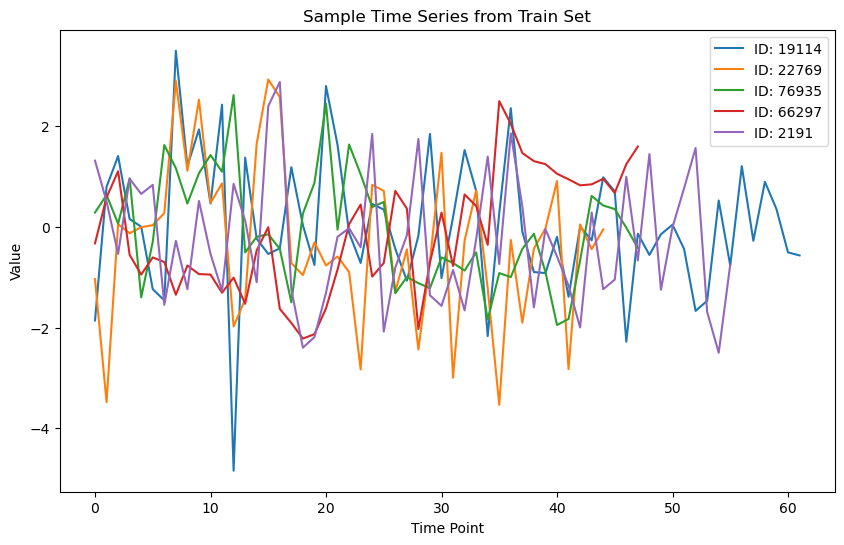

In [10]:
sample_train_data = train_df.select("id", "values").limit(5).collect()


plt.figure(figsize=(10, 6))
for row in sample_train_data:
    plt.plot(row["values"], label=f'ID: {row["id"]}')

plt.title("Sample Time Series from Train Set")
plt.xlabel("Time Point")
plt.ylabel("Value")
plt.legend()
plt.show()

In [11]:
label_distribution = train_df.groupBy("label").count()

label_distribution.show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|57820|
|  1.0|22180|
+-----+-----+



In [12]:
missing_values_train = train_df.select([count(col(c).isNull().cast("int")).alias(c) for c in train_df.columns])

missing_values_train.show()


+-----+-----+------+-----+
|   id|dates|values|label|
+-----+-----+------+-----+
|80000|80000| 80000|80000|
+-----+-----+------+-----+



In [13]:
missing_values_test = test_df.select([count(col(c).isNull().cast("int")).alias(c) for c in test_df.columns])
missing_values_test.show()

+-----+-----+------+
|   id|dates|values|
+-----+-----+------+
|20000|20000| 20000|
+-----+-----+------+



In [14]:
exploded_test_df = test_df.withColumn("value", explode(col("values")))


summary_stats_test = exploded_test_df.select(
    mean(col("value")).alias("mean"),
    stddev(col("value")).alias("stddev"),
    min(col("value")).alias("min"),
    max(col("value")).alias("max"),
    count(col("value")).alias("count")
)


summary_stats_test.show()

+--------------------+------------------+-----+----+-------+
|                mean|            stddev|  min| max|  count|
+--------------------+------------------+-----+----+-------+
|-0.03032562516091...|1.2242395274936362|-7.86|9.57|1285873|
+--------------------+------------------+-----+----+-------+



In [15]:
train_features = exploded_train_df.groupBy("id").agg(
    mean(col("value")).alias("mean_value"),  # Среднее значение
    stddev(col("value")).alias("stddev_value"),  # Стандартное отклонение
    min(col("value")).alias("min_value"),  # Минимум
    max(col("value")).alias("max_value"),  # Максимум
    percentile_approx(col("value"), 0.5).alias("median_value"),  # Медиана (0.5 квантиль)
    percentile_approx(col("value"), 0.25).alias("q1_value"),  # Первый квартиль (0.25 квантиль)
    percentile_approx(col("value"), 0.75).alias("q3_value")  # Третий квартиль (0.75 квантиль)
)


In [16]:
train_features_with_label = train_features.join(train_df.select("id", "label"), on="id")

# Шаг 6: Генерация статистических признаков для тестовой выборки (без меток классов)
test_features = exploded_test_df.groupBy("id").agg(
    mean(col("value")).alias("mean_value"),
    stddev(col("value")).alias("stddev_value"),
    min(col("value")).alias("min_value"),
    max(col("value")).alias("max_value"),
    percentile_approx(col("value"), 0.5).alias("median_value"),
    percentile_approx(col("value"), 0.25).alias("q1_value"),
    percentile_approx(col("value"), 0.75).alias("q3_value")
)

In [31]:
train_pandas = train_features_with_label.toPandas().dropna()
test_pandas = test_features.toPandas()


In [35]:
train_pandas

,id,mean_value,stddev_value,min_value,max_value,median_value,q1_value,q3_value,label
0,0,-0.024030,1.040184,-1.630000,5.57,-0.16,-0.55,0.15,0.0
1,19,-0.013846,1.233401,-2.310000,3.85,-0.32,-0.86,0.72,0.0
2,22,-0.020000,1.120295,-2.830000,3.38,-0.13,-0.79,0.70,0.0
3,26,-0.262848,1.415646,-3.134766,3.15,-0.38,-1.21,0.58,1.0
4,29,0.090845,1.141477,-2.230000,3.37,0.09,-0.68,0.69,0.0
...,...,...,...,...,...,...,...,...,...
79995,99818,0.064643,1.265482,-3.710000,2.42,0.15,-0.97,1.14,0.0
79996,99845,-0.003696,1.202267,-1.950000,3.50,-0.24,-0.93,0.70,0.0
79997,99912,0.010976,1.175967,-2.150000,4.69,-0.18,-0.67,0.48,0.0
79998,99924,0.024474,0.989387,-2.160000,1.51,0.33,-0.43,0.70,0.0


In [36]:
test_pandas


,id,mean_value,stddev_value,min_value,max_value,median_value,q1_value,q3_value
0,7,0.112500,1.114261,-1.650000,3.89,-0.03,-0.66,0.53
1,188,0.008182,1.261270,-1.630000,4.55,-0.15,-0.85,0.21
2,278,-0.136200,1.177255,-2.560000,2.21,-0.10,-0.83,0.81
3,293,-0.019577,1.007651,-1.330000,3.13,-0.36,-0.72,0.40
4,347,0.054462,1.177594,-2.570000,4.30,-0.07,-0.58,0.60
...,...,...,...,...,...,...,...,...
19995,99902,-0.130196,1.207140,-3.430000,2.55,-0.10,-1.15,0.75
19996,99906,-0.236796,1.563052,-4.290000,3.65,-0.11,-1.02,0.60
19997,99955,0.160923,1.272622,-1.970000,3.91,-0.17,-0.71,1.16
19998,99980,-0.082200,1.300969,-2.620000,3.05,-0.28,-0.81,0.85


In [37]:

# Шаг 8: Разделение данных на признаки и метки
X = train_pandas.drop(columns=["id", "label"])  # Признаки
y = train_pandas["label"]  # Метки


In [38]:

# Шаг 9: Обучение модели RandomForest с использованием scikit-learn
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем модель случайного леса
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [39]:

# Шаг 10: Оценка модели на валидационной выборке
y_val_pred = clf.predict_proba(X_val)[:, 1]  # Предсказания вероятности класса 1
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC: {roc_auc}")




Validation ROC AUC: 0.8184166812463642


In [40]:

# Шаг 11: Прогнозирование для тестовой выборки
X_test = test_pandas.drop(columns=["id"])  # Признаки тестовой выборки
test_pandas["score"] = clf.predict_proba(X_test)[:, 1]  # Вероятности для класса 1

# Шаг 12: Сохранение предсказаний в файл submission.csv
submission = test_pandas[["id", "score"]]
submission.to_csv("submission.csv", index=False)


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

24/10/23 12:51:12 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1037455 ms exceeds timeout 120000 ms
24/10/23 12:51:12 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/23 12:51:19 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at s

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [27]:
X.dropna()

,mean_value,stddev_value,min_value,max_value,median_value,q1_value,q3_value
0,-0.024030,1.040184,-1.630000,5.57,-0.16,-0.55,0.15
1,-0.013846,1.233401,-2.310000,3.85,-0.32,-0.86,0.72
2,-0.020000,1.120295,-2.830000,3.38,-0.13,-0.79,0.70
3,-0.262848,1.415646,-3.134766,3.15,-0.38,-1.21,0.58
4,0.090845,1.141477,-2.230000,3.37,0.09,-0.68,0.69
...,...,...,...,...,...,...,...
79995,0.064643,1.265482,-3.710000,2.42,0.15,-0.97,1.14
79996,-0.003696,1.202267,-1.950000,3.50,-0.24,-0.93,0.70
79997,0.010976,1.175967,-2.150000,4.69,-0.18,-0.67,0.48
79998,0.024474,0.989387,-2.160000,1.51,0.33,-0.43,0.70
